<a href="https://colab.research.google.com/github/matule00/SGE/blob/main/NN_SVR_peak_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import os
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input, LeakyReLU, LSTM
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau, Callback

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 220)

In [78]:
SVR = pd.read_csv('SVR_peak.csv')
SVR.drop(columns=['extrema'], inplace=True)
SVR['Time'] = pd.to_datetime(SVR['Time'])

In [137]:
def evaluate_predictions(predictions, threshold, use_absolute=False):
    """
    Evaluates the predictions based on a given threshold and optionally uses absolute values for evaluation.
    Computes Mean Squared Error (MSE) for the predictions (excluding True Negatives).

    Parameters:
        predictions (pd.DataFrame): DataFrame with 'actual_value' and 'predicted_value'.
        threshold (float): The threshold value to classify predictions as > threshold or ≤ threshold.
        use_absolute (bool): If True, uses absolute values for both actual and predicted values in calculations.
    """
    # Use absolute values if specified
    if use_absolute:
        predictions['eval_actual_value'] = np.abs(predictions['actual_value'])
        predictions['eval_predicted_value'] = np.abs(predictions['predicted_value'])
    else:
        predictions['eval_actual_value'] = predictions['actual_value']
        predictions['eval_predicted_value'] = predictions['predicted_value']

    # Define the confusion matrix categories
    TP = ((predictions['eval_actual_value'] > threshold) & (predictions['eval_predicted_value'] > threshold)).sum()  # True Positive
    FP = ((predictions['eval_actual_value'] <= threshold) & (predictions['eval_predicted_value'] > threshold)).sum()  # False Positive
    TN = ((predictions['eval_actual_value'] <= threshold) & (predictions['eval_predicted_value'] <= threshold)).sum()  # True Negative
    FN = ((predictions['eval_actual_value'] > threshold) & (predictions['eval_predicted_value'] <= threshold)).sum()  # False Negative

    # Calculate MSE excluding True Negatives
    predictions_non_tn = predictions[(predictions['eval_actual_value'] > threshold) |
                                     (predictions['eval_predicted_value'] > threshold)]
    mse = mean_squared_error(predictions_non_tn['actual_value'], predictions_non_tn['predicted_value'])

    # Create the confusion matrix
    conf_matrix = pd.DataFrame([[TP, FP], [FN, TN]],
                               columns=[f'Predicted > {threshold}', f'Predicted ≤ {threshold}'],
                               index=[f'Actual > {threshold}', f'Actual ≤ {threshold}'])

    # Plot the heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
                annot_kws={'size': 14}, linewidths=0.5)
    title_suffix = " (Absolute Values)" if use_absolute else ""
    plt.title(f'Confusion Matrix: Evaluation of Predictions > {threshold}{title_suffix}', fontsize=16)
    plt.xlabel('Predicted', fontsize=12)
    plt.ylabel('Actual', fontsize=12)
    plt.show()

    # Additional metrics: Percentage of correct predictions
    total_predictions = TP + TN + FP + FN
    correct_predictions = TP + TN
    percentage_correct = (correct_predictions / total_predictions) * 100 if total_predictions > 0 else 0

    # Print results
    print(f"Total predictions (all values): {total_predictions}")
    print(f"Correct predictions (TP + TN): {correct_predictions}")
    print(f"Percentage of correct predictions: {percentage_correct:.2f}%")
    print(f"Mean Squared Error (excluding True Negatives): {mse:.4f}")
    print(f"Mean Standard Deviation Error (excluding True Negatives): {np.sqrt(mse):.4f}")

In [115]:
def plot_filtered_predictions(predictions, start_time='2024-09-01', end_time='2024-09-10'):
    filtered_predictions = predictions[(predictions['predicted_time'] < end_time) & (predictions['predicted_time'] > start_time)]

    plt.figure(figsize=(20, 10))
    plt.scatter(
        filtered_predictions['predicted_time'],
        filtered_predictions['actual_value'],
        label='Actual SVR', alpha=0.5, s=60
    )
    plt.scatter(
        filtered_predictions['predicted_time'],
        filtered_predictions['predicted_value'],
        label='Predicted SVR', color='orange', s=60
    )
    plt.scatter(
        filtered_predictions['predicted_time'],
        filtered_predictions['smoothed_SVR_at_predicted_time'],
        label='Smoothed SVR', color='green', s=60
    )
    plt.title('Prediction of Next Extrema and Time (Filtered)', fontsize=16)
    plt.xlabel('Time', fontsize=14)
    plt.ylabel('SVR', fontsize=14)
    plt.xticks(rotation=45)
    plt.legend(fontsize=12)
    plt.grid(alpha=0.3)
    plt.show()

In [58]:
def train_model(X_train, X_test, y_train, y_test, scaler_y, NN_model, lr=0.005, patience_early_stop=10, patience_scheduler=5, num_of_epochs=40, peaks=True):
    if peaks:
        title_suffix = "for Peaks"
        checkpoint_path = "weights_peaks.weights.h5"
    else:
        title_suffix = "for Time"
        checkpoint_path = "weights_time.weights.h5"

    # Create a callback to save the model's weights
    checkpoint_callback = ModelCheckpoint(
        filepath=checkpoint_path,
        save_weights_only=True,  # Only save the weights
        monitor='val_loss',      # Monitor validation loss
        mode='min',              # Save weights for minimum val_loss
        save_best_only=True,     # Save only the best weights
        verbose=1
    )

    # Compile the model

    NN_model.compile(optimizer=Adam(learning_rate = lr), loss='mse', metrics=['mse'])

    # Train the model
    early_stopping = EarlyStopping(monitor='val_loss', patience=patience_early_stop, restore_best_weights=True)
    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=patience_scheduler, min_lr=1e-6)
    history = NN_model.fit(X_train, y_train, validation_split=0.2, epochs=num_of_epochs, batch_size=16, callbacks=[early_stopping, lr_scheduler, checkpoint_callback], verbose=1)

    # Evaluate the model
    test_loss, test_mse = NN_model.evaluate(X_test, y_test)
    print(f"Test Mean Squared Error: {test_mse}")

    # Predict and visualize both outputs
    y_pred = NN_model.predict(X_test)

    y_pred = scaler_y.inverse_transform(y_pred)
    y_test = scaler_y.inverse_transform(y_test)

    # Calculate Mean Squared Error
    mse = mean_squared_error(y_test, y_pred)

    print(f"Mean Squared Error {title_suffix}: {mse}")


    # Visualize True vs Predicted for Extrema Value
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.scatter(y_test, y_pred, alpha=0.6)
    plt.xlabel(f'True Values {title_suffix}')
    plt.ylabel(f'Predicted Values {title_suffix}')
    plt.title(f'True vs Predicted Values {title_suffix}')

    plt.tight_layout()
    plt.show()

In [62]:
def prepare_data_and_model(SVR):
    valid_rows = SVR.dropna(subset=['time_prev', 'amp_diff', 'prev_extrema_value',
                                'mfrr5', 'mfrr_p', 'mfrr_m',
                                'last_values_1', 'last_values_2',
                                'last_values_3', 'last_values_4',
                                'last_values_5', 'last_values_6',
                                'last_values_7', 'last_values_8',
                                'last_values_9', 'last_values_10',
                                'smoothed_SVR', 'previous_inflections'])

    print(valid_rows.head(10))
    september_rows = valid_rows[valid_rows['Time'] < '2024-09-30 00:00:00']
    X = september_rows[['time_prev', 'amp_diff', 'prev_extrema_value',
                                    'last_values_1', 'last_values_2',
                                    'last_values_3', 'last_values_4',
                                    'last_values_5', 'last_values_6',
                                    'last_values_7', 'last_values_8',
                                    'last_values_9', 'last_values_10',
                                    'smoothed_SVR', 'previous_inflections']].values
    y_peak = september_rows[['next_extrema_value']].values  # Two outputs: extrema and time
    y_time = september_rows[['time_next']].values

    indices_september = september_rows.index

    # Split data into training and testing sets
    X_train, X_test, y_peak_train, y_peak_test, y_time_train, y_time_test, train_indices, test_indices = train_test_split(X, y_peak, y_time, indices_september, test_size=0.2, random_state=42)

    # Standardize the input data
    scaler_X = StandardScaler()
    X_train = scaler_X.fit_transform(X_train)
    X_test = scaler_X.transform(X_test)

    X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))  # (samples, time_steps, features)
    X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

    scaler_y = StandardScaler()
    y_peak_train = scaler_y.fit_transform(y_peak_train)
    y_peak_test = scaler_y.transform(y_peak_test)

    model_peak = Sequential([
        Input(shape=(1, X_train.shape[2])),
        LSTM(128, return_sequences=True, activation='tanh'),
        Dropout(0.2),
        LSTM(64, return_sequences=True, activation='tanh'),
        Dropout(0.2),
        LSTM(32, return_sequences=True, activation='tanh'),
        Dropout(0.2),
        LSTM(1, activation='linear')
    ])

    return X_train, X_test, y_peak_train, y_peak_test, y_time_train, y_time_test, train_indices, test_indices, model_peak, scaler_X, scaler_y

#Peak and time model

In [104]:
X_train, X_test, y_peak_train, y_peak_test, y_time_train, y_time_test, train_indices, test_indices, model_peak, scaler_X, scaler_y = prepare_data_and_model(SVR)

                  Time    afrr_p    afrr_m  mfrr_p  mfrr_m  mfrr5       SVR  smoothed_SVR  first_derivative  second_derivative  inflection  time_prev  time_next   amp_diff  prev_extrema_value  next_extrema_value  \
15 2024-09-01 00:15:00  25.58926   0.00000     0.0     0.0    0.0  25.58926     26.067932         -3.037167           0.871031         2.0        2.0        2.0  -6.212567           32.280499           23.339488   
24 2024-09-01 00:24:00  15.10482   0.00000     0.0     0.0    0.0  15.10482     16.520337         -2.513529           0.132981         2.0        5.0        4.0  -9.447137           25.967475            7.222441   
28 2024-09-01 00:28:00   7.72944   0.00000     0.0     0.0    0.0   7.72944      7.222441         -3.149459           0.102238         2.0        9.0        3.0 -18.745034           25.967475            3.880704   
33 2024-09-01 00:33:00  11.18180   0.00000     0.0     0.0    0.0  11.18180     10.315592          2.528473          -0.919940         2.0  

Epoch 1/50
181/184 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.9098 - mse: 0.9098
Epoch 1: val_loss improved from inf to 0.21661, saving model to weights_peaks.weights.h5
184/184 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 0.9020 - mse: 0.9020 - val_loss: 0.2166 - val_mse: 0.2166 - learning_rate: 0.0010
Epoch 2/50
181/184 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1877 - mse: 0.1877
Epoch 2: val_loss improved from 0.21661 to 0.14687, saving model to weights_peaks.weights.h5
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1870 - mse: 0.1870 - val_loss: 0.1469 - val_mse: 0.1469 - learning_rate: 0.0010
Epoch 3/50
176/184 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1590 - mse: 0.1590
Epoch 3: val_loss improved from 0.14687 to 0.13353, saving model to weights_peaks.weights.h5
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1572 - mse: 0.1572 - val_loss: 0.1335 - val_mse: 0.1335 - learning_rate: 0.0010
Epoch 4/50
178/184 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1125 - mse: 0.1125
Epoch 4

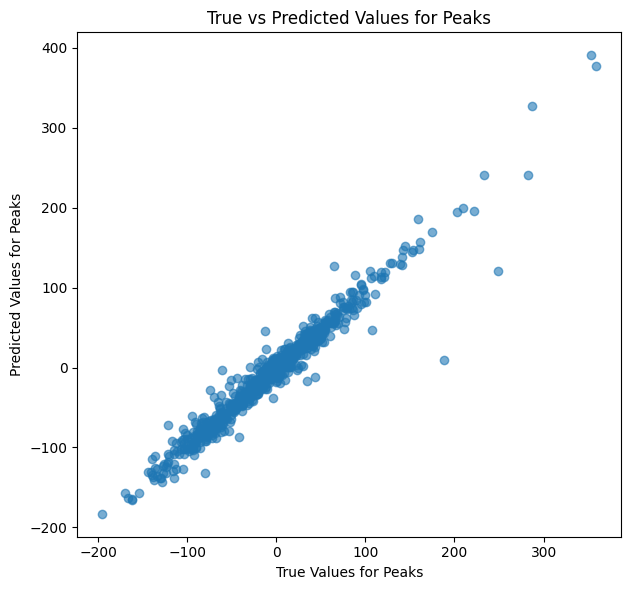

In [80]:
train_model(X_train, X_test, y_peak_train, y_peak_test, scaler_y, model_peak, lr=0.001, patience_early_stop=8, patience_scheduler=4, num_of_epochs=50)

In [ ]:
model_time = Sequential([
    Input(shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dense(64),
    LeakyReLU(0.01),  # Leaky ReLU activation
    Dense(128),
    LeakyReLU(0.01),  # Leaky ReLU activation
    Dropout(0.1),
    Dense(64),
    LeakyReLU(0.01),  # Leaky ReLU activation
    Dense(32),
    LeakyReLU(0.01),  # Leaky ReLU activation
    Dropout(0.1),
    Dense(1)  # Output layer (no activation needed for regression)
])

Epoch 1/150
323/329 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.5950 - mse: 7.5950
Epoch 1: val_loss improved from inf to 4.26113, saving model to weights_time.weights.h5
329/329 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 7.5579 - mse: 7.5579 - val_loss: 4.2611 - val_mse: 4.2611 - learning_rate: 0.0010
Epoch 2/150
319/329 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.9990 - mse: 3.9990
Epoch 2: val_loss improved from 4.26113 to 3.72486, saving model to weights_time.weights.h5
329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 3.9881 - mse: 3.9881 - val_loss: 3.7249 - val_mse: 3.7249 - learning_rate: 0.0010
Epoch 3/150
299/329 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.2202 - mse: 3.2202
Epoch 3: val_loss improved from 3.72486 to 3.57713, saving model to weights_time.weights.h5
329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 3.2296 - mse: 3.2296 - val_loss: 3.5771 - val_mse: 3.5771 - learning_rate: 0.0010
Epoch 4/150
328/329 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.1168 - mse: 3.1168
Epoch 4

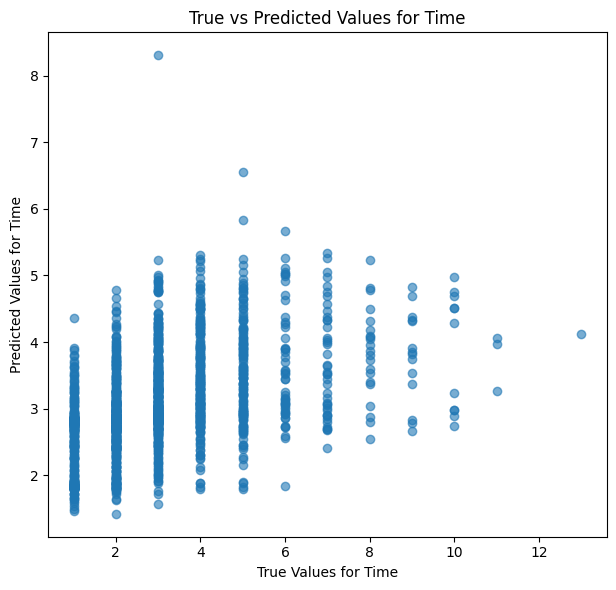

In [ ]:
model_time = Sequential([
    Input(shape=(X.shape[1],)),
    Dense(16),
    LeakyReLU(0.01),  # Leaky ReLU activation
    Dropout(0.1),
    Dense(8),
    LeakyReLU(0.01),  # Leaky ReLU activation
    Dense(1)  # Output layer (no activation needed for regression)
])


train_model(X, y_time, model_time, lr=0.001, patience_early_stop=8, patience_scheduler=5, num_of_epochs=50, peaks=False)

##Evaluation of model

In [140]:
model_peak.load_weights('/content/weights_peaks.weights.h5')

print(X_test.shape)
print(X_train.shape)

X = np.concatenate((X_train, X_test), axis=0)

print(X.shape)
y_peak = np.concatenate((y_peak_train, y_peak_test), axis=0)

y_pred_peak = model_peak.predict(X)

y_pred_peak = scaler_y.inverse_transform(y_pred_peak)
y_peak = scaler_y.inverse_transform(y_peak)

y_time = np.concatenate((y_time_train, y_time_test), axis=0)

indices = np.concatenate((train_indices, test_indices), axis=0)

print(y_pred_peak.shape)
print(y_peak.shape)
print(indices.shape)


(917, 1, 15)
(3668, 1, 15)
(4585, 1, 15)
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
(4585, 1)
(4585, 1)
(4585,)


In [141]:
predictions = pd.DataFrame({
    'actual_value': y_peak[:,0],                # Actual extrema value
    'predicted_value': y_pred_peak[:,0],     # Predicted extrema value
    'actual_time': y_time[:,0],                # Actual time to next extrema
    'predicted_time_offset': y_time[:,0],  # Predicted time offset
}, index=indices)  # Attach original indices

# Step 4: Calculate predicted time using the original SVR DataFrame
predicted_time_values = (
    SVR.loc[predictions.index, 'Time'] + pd.to_timedelta(predictions['predicted_time_offset'], unit='m')
)
predictions['predicted_time'] = predicted_time_values

# Step 5: Find SVR values at predicted times
actual_svr_at_predicted_time = []
smoothed_svr = []

for predicted_time in predicted_time_values:
    closest_idx = (SVR['Time'] - predicted_time).abs().idxmin()
    actual_svr_at_predicted_time.append(SVR.loc[closest_idx, 'SVR'])
    smoothed_svr.append(SVR.loc[closest_idx, 'smoothed_SVR'])

# Add SVR values to the DataFrame
predictions['actual_svr_at_predicted_time'] = actual_svr_at_predicted_time
predictions['smoothed_SVR_at_predicted_time'] = smoothed_svr

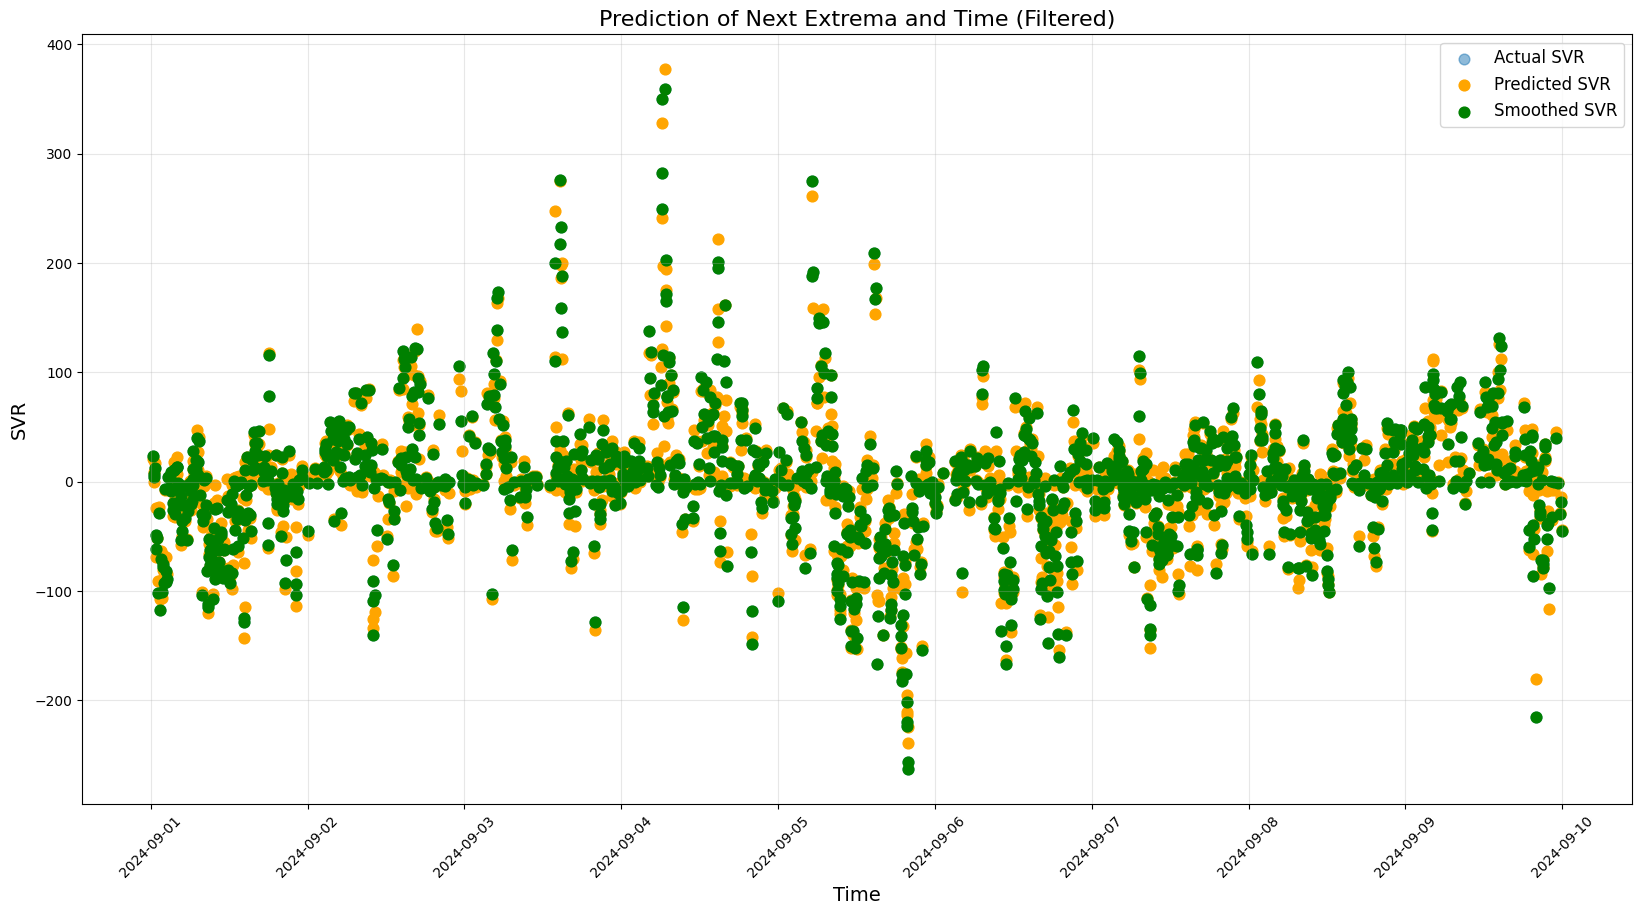

In [142]:
plot_filtered_predictions(predictions)

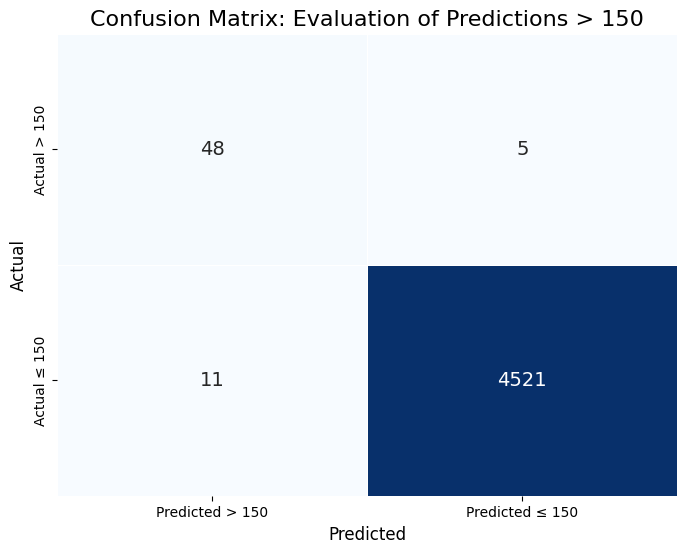

Total predictions (all values): 4585
Correct predictions (TP + TN): 4569
Percentage of correct predictions: 99.65%
Mean Squared Error (excluding True Negatives): 1891.8181
Mean Standard Deviation Error (excluding True Negatives): 43.4950


In [143]:
evaluate_predictions(predictions, threshold=150, use_absolute=False)

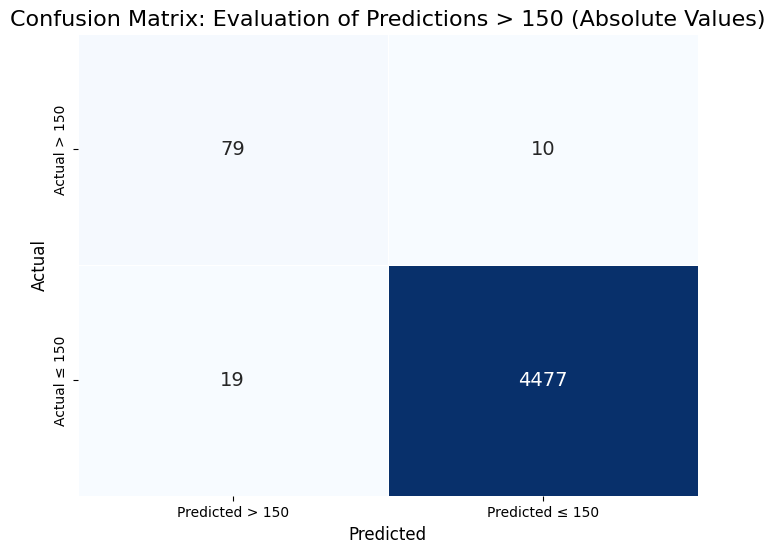

Total predictions (all values): 4585
Correct predictions (TP + TN): 4556
Percentage of correct predictions: 99.37%
Mean Squared Error (excluding True Negatives): 1277.7717
Mean Standard Deviation Error (excluding True Negatives): 35.7459


In [144]:
evaluate_predictions(predictions, threshold=150, use_absolute=True)

In [ ]:
october_rows = valid_rows[valid_rows['Time'] > '2024-10-01 00:00:00']
X_oct = october_rows[['time_prev', 'amp_diff', 'prev_extrema_value',
                                'last_values_1', 'last_values_2',
                                'last_values_3', 'last_values_4',
                                'last_values_5', 'last_values_6',
                                'last_values_7', 'last_values_8',
                                'last_values_9', 'last_values_10',
                                'smoothed_SVR', 'previous_inflections']].values
y_oct_val = october_rows[['next_extrema_value']].values  # Two outputs: extrema and time
y_oct_time = october_rows[['time_next']].values

indices_oct = october_rows.index

scaler = StandardScaler()
X_oct = scaler.fit_transform(X_oct)

model_peak.fit(X_oct, y_oct_val, epochs=5, batch_size=32, verbose=1)
y_pred_oct = model_peak.predict(X_oct)

print(y_pred_oct.shape)
print(y_oct_val.shape)
print(indices_oct.shape)

Epoch 1/5
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 740.3737 - mse: 740.3737
Epoch 2/5
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 182.0548 - mse: 182.0548
Epoch 3/5
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 144.2172 - mse: 144.2172
Epoch 4/5
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 146.7311 - mse: 146.7311
Epoch 5/5
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 135.7791 - mse: 135.7791
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
(6688, 1)
(6688, 1)
(6688,)


In [ ]:
predictions_oct = pd.DataFrame({
    'actual_value': y_oct_val[:, 0],                # Actual extrema value
    'predicted_value': y_pred_oct[:, 0],     # Predicted extrema value
    'actual_time': y_oct_time[:, 0],                # Actual time to next extrema
    'predicted_time_offset': y_oct_time[:, 0],  # Predicted time offset
}, index=indices_oct)  # Attach original indices

# Step 4: Calculate predicted time using the original SVR DataFrame
predicted_time_values_oct = (
    SVR.loc[predictions_oct.index, 'Time'] + pd.to_timedelta(predictions_oct['predicted_time_offset'], unit='m')
)
predictions_oct['predicted_time'] = predicted_time_values_oct

# Step 5: Find SVR values at predicted times
actual_svr_at_predicted_time_oct = []
smoothed_svr_oct = []

for predicted_time in predicted_time_values_oct:
    closest_idx = (SVR['Time'] - predicted_time).abs().idxmin()
    actual_svr_at_predicted_time_oct.append(SVR.loc[closest_idx, 'SVR'])
    smoothed_svr_oct.append(SVR.loc[closest_idx, 'smoothed_SVR'])

# Add SVR values to the DataFrame
predictions_oct['actual_svr_at_predicted_time'] = actual_svr_at_predicted_time_oct
predictions_oct['smoothed_SVR_at_predicted_time'] = smoothed_svr_oct

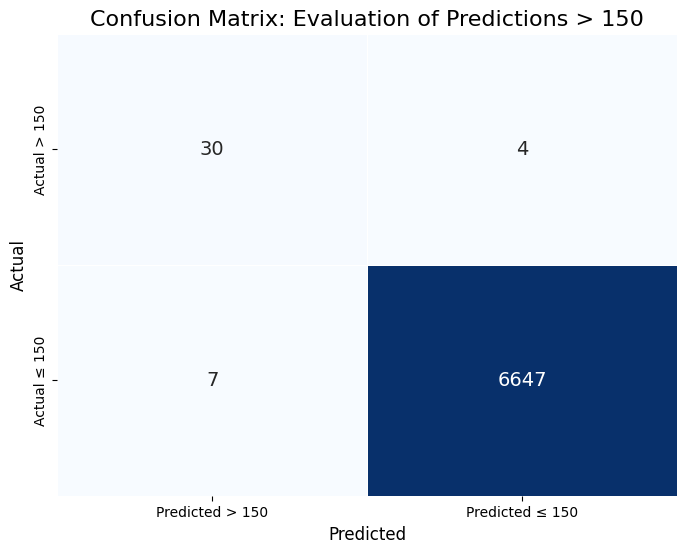

Total predictions (all values): 6688
Correct predictions (TP + TN): 6677
Percentage of correct predictions: 99.84%
Mean Squared Error (excluding True Negatives): 1284.5734
Mean Standard Deviation Error (excluding True Negatives): 35.8409


In [ ]:
evaluate_predictions(predictions_oct, threshold=150, use_absolute=False)

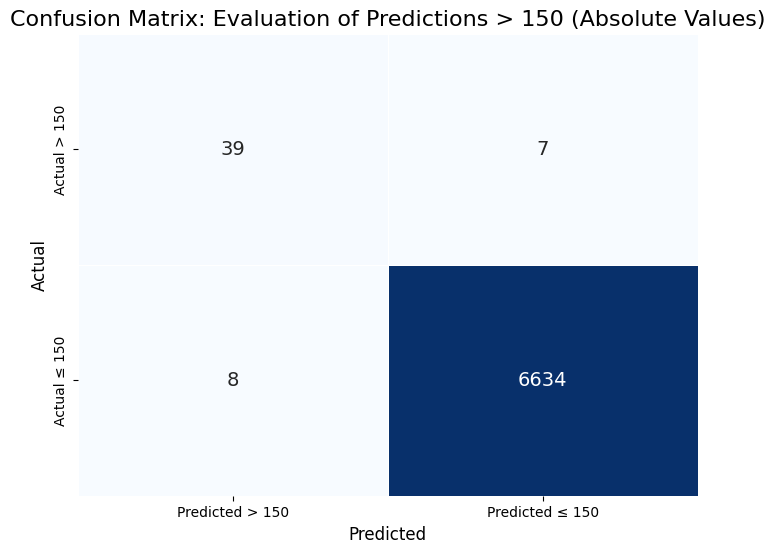

Total predictions (all values): 6688
Correct predictions (TP + TN): 6673
Percentage of correct predictions: 99.78%
Mean Squared Error (excluding True Negatives): 1012.0616
Mean Standard Deviation Error (excluding True Negatives): 31.8129


In [ ]:
evaluate_predictions(predictions_oct, threshold=150, use_absolute=True)

In [ ]:
def visualize_predictions(predictions):
    # Visualize True vs Predicted for Extrema Value
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.scatter(predictions['actual_value'], predictions['predicted_value'], alpha=0.6)
    plt.xlabel('True Extrema Values')
    plt.ylabel('Predicted Extrema Values')
    plt.title('True vs Predicted Extrema Values')

    # Visualize True vs Predicted for Time
    plt.subplot(1, 2, 2)
    plt.scatter(predictions['actual_time'], predictions['predicted_time_offset'], alpha=0.6)
    plt.xlabel('True Time Values')
    plt.ylabel('Predicted Time Values')
    plt.title('True vs Predicted Time Values')

    plt.tight_layout()
    plt.show()

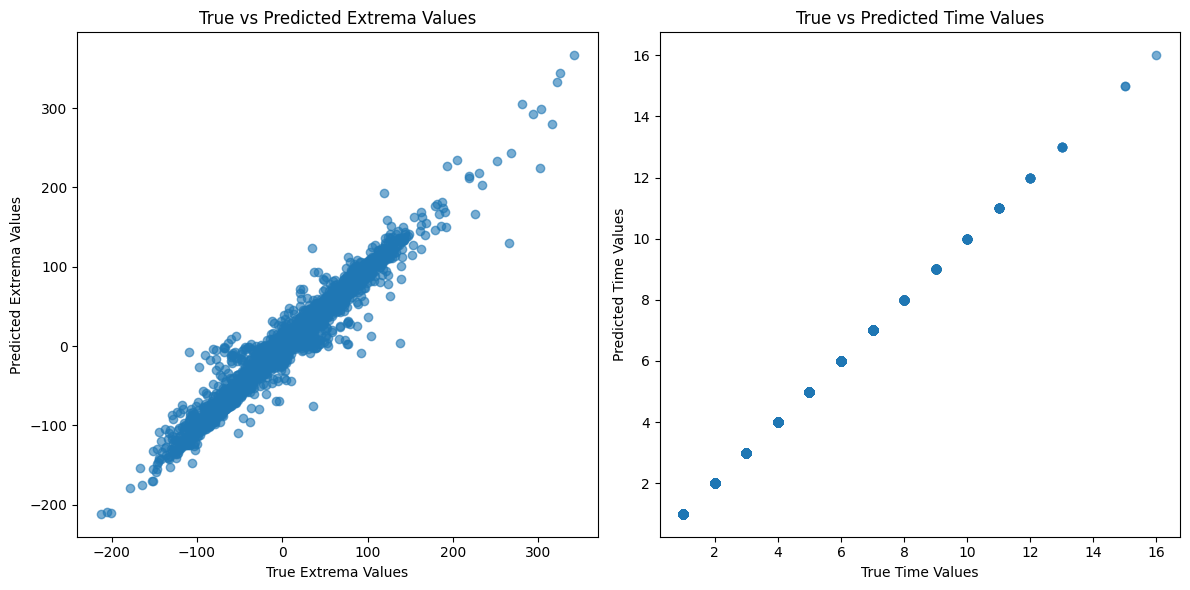

In [ ]:
visualize_predictions(predictions_oct)

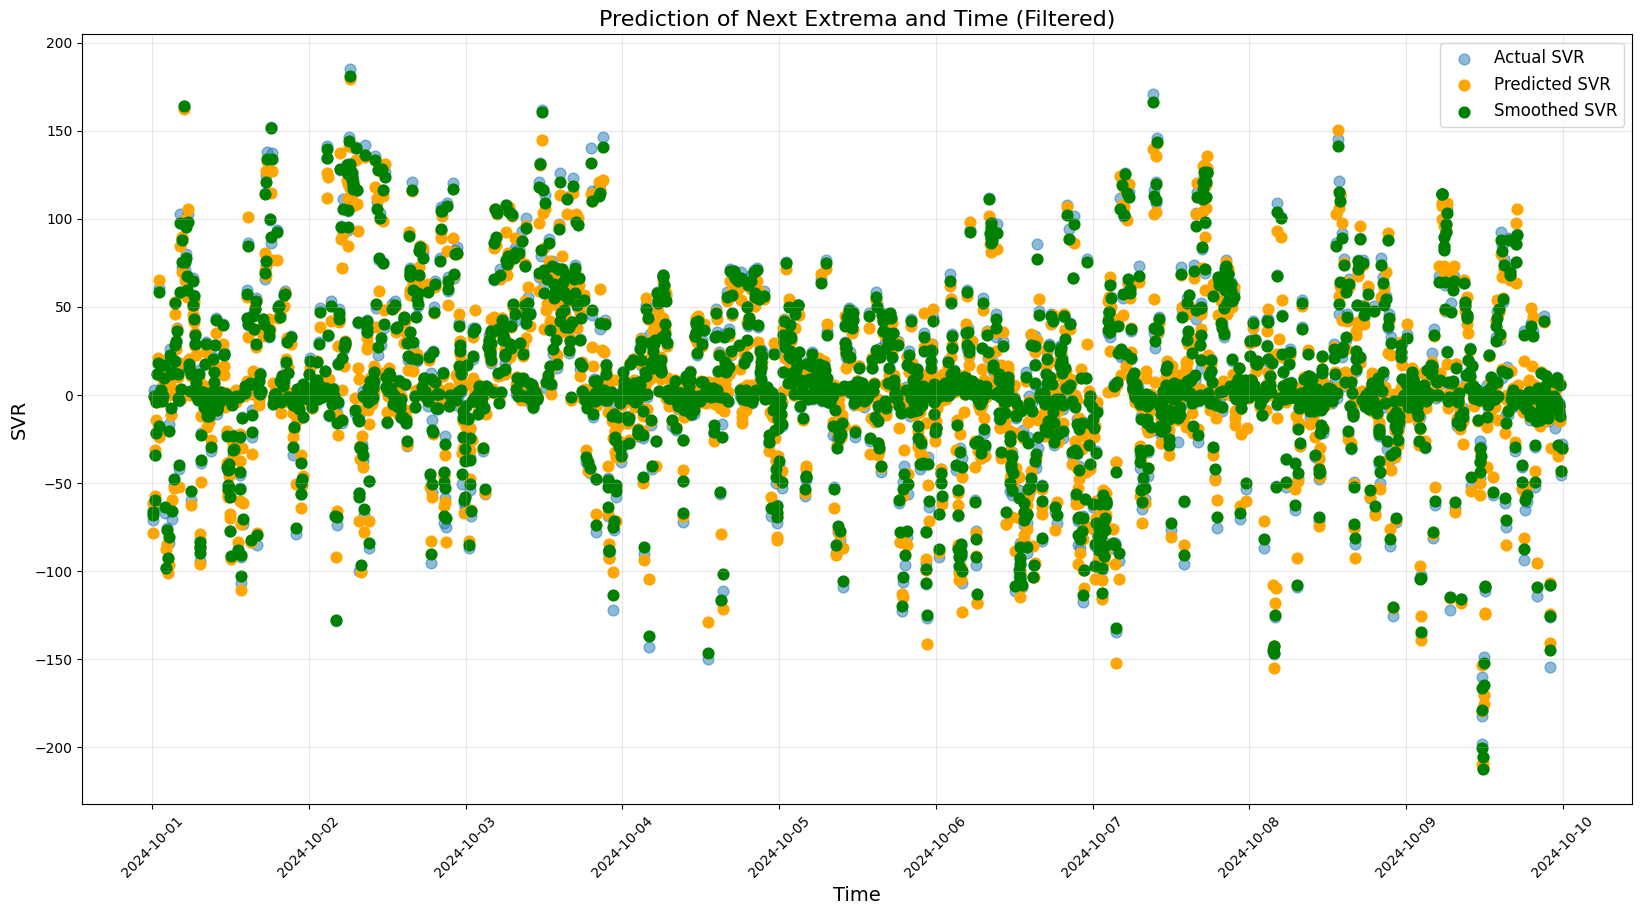

In [ ]:
plot_filtered_predictions(predictions_oct, '2024-10-01', '2024-10-10')

#Predicting the sequence

In [34]:
valid_rows_serie = SVR.dropna(subset=['time_prev', 'amp_diff', 'prev_extrema_value',
                                'last_values_1', 'last_values_2',
                                'last_values_3', 'last_values_4',
                                'last_values_5', 'last_values_6',
                                'last_values_7', 'last_values_8',
                                'last_values_9', 'last_values_10',
                                'smoothed_SVR', 'previous_inflections'])
september_rows_serie = valid_rows_serie[valid_rows_serie['Time'] < '2024-09-30 00:00:00']
X = september_rows_serie[['time_prev', 'amp_diff', 'prev_extrema_value',
                                'last_values_1', 'last_values_2',
                                'last_values_3', 'last_values_4',
                                'last_values_5', 'last_values_6',
                                'last_values_7', 'last_values_8',
                                'last_values_9', 'last_values_10',
                                'smoothed_SVR', 'previous_inflections']].values
y_serie = september_rows_serie[['next_values_1', 'next_values_2', 'next_values_3']].values  # Two outputs: extrema and time

indices = september_rows_serie.index

# Split data into training and testing sets
X_train, X_test, y_serie_train, y_serie_test, train_indices, test_indices = train_test_split(X, y_serie, indices, test_size=0.2, random_state=42)

# Standardize the input data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))  # (samples, time_steps, features)
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

scaler_y = StandardScaler()
y_train = scaler_y.fit_transform(y_serie_train)
y_test = scaler_y.transform(y_serie_test)

In [45]:
def train_LSTM_model(X, y, lr=0.005, patience_early_stop=10, patience_scheduler=5, num_of_epochs=40):
    checkpoint_path = "serie.weights.h5"

    class RealTimePlotCallback(Callback):
        def __init__(self):
            self.epochs = []
            self.losses = []
            self.val_losses = []
            self.fig, self.ax = plt.subplots()

        def on_train_begin(self, logs=None):
            self.fig.show()
            self.fig.canvas.draw()

        def on_epoch_end(self, epoch, logs=None):
            # Update data
            self.epochs.append(epoch)
            self.losses.append(logs['loss'])
            self.val_losses.append(logs.get('val_loss'))

            # Clear previous plots
            self.ax.clear()
            self.ax.plot(self.epochs, self.losses, label='Training Loss', color='blue')
            if self.val_losses[0] is not None:
                self.ax.plot(self.epochs, self.val_losses, label='Validation Loss', color='orange')
            self.ax.set_title('Training and Validation Loss')
            self.ax.set_xlabel('Epochs')
            self.ax.set_ylabel('Loss')
            self.ax.legend()

            # Redraw the figure
            self.fig.canvas.draw()

    plot_callback = RealTimePlotCallback()


    # Create a callback to save the model's weights
    checkpoint_callback = ModelCheckpoint(
        filepath=checkpoint_path,
        save_weights_only=True,  # Only save the weights
        monitor='val_loss',      # Monitor validation loss
        mode='min',              # Save weights for minimum val_loss
        save_best_only=True,     # Save only the best weights
        verbose=1
    )

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Standardize the input data
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))  # (samples, time_steps, features)
    X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

    scaler_y = StandardScaler()
    y_train = scaler_y.fit_transform(y_train)
    y_test = scaler_y.transform(y_test)

    model = Sequential([
        Input(shape=(1, X_train.shape[2])),
        LSTM(100, return_sequences=True, activation='tanh'),  # First LSTM layer with ReLU activation
        Dropout(0.2),
        LSTM(64, return_sequences=True, activation='tanh'),                         # Fourth LSTM layer (last, no return_sequences)
        Dropout(0.2),
        LSTM(32, return_sequences=True, activation='tanh'),                         # Fourth LSTM layer (last, no return_sequences)
        Dropout(0.2),
        LSTM(3, activation='linear')                         # Final LSTM layer to predict 5 values
    ])
    # Compile the model

    model.compile(optimizer=RMSprop(learning_rate = lr), loss='mse', metrics=['mse'])

    # Train the model
    early_stopping = EarlyStopping(monitor='val_loss', patience=patience_early_stop, restore_best_weights=True)
    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=patience_scheduler, min_lr=1e-6)
    history = model.fit(X_train, y_train, validation_split=0.2, epochs=num_of_epochs, batch_size=16, callbacks=[early_stopping, lr_scheduler, checkpoint_callback, plot_callback], verbose=1)

    # Evaluate the model
    test_loss, test_mse = model.evaluate(X_test, y_test)
    print(f"Test Mean Squared Error: {test_mse}")


    # Predict and visualize both outputs
    y_pred = model.predict(X_test)
    y_pred = scaler_y.inverse_transform(y_pred)
    y_test = scaler_y.inverse_transform(y_test)

    # Calculate Mean Squared Error
    mse = mean_squared_error(y_test, y_pred)

    print(f"Mean Squared Error: {mse}")

    # Assuming time ranges match `y_test_original` and `y_pred`
    y_test = y_test.flatten()
    y_pred = y_pred.flatten()

    # Visualize True vs Predicted for Extrema Value
    plt.figure(figsize=(12, 6))
    plt.plot(y_test[:100], label='True Values')  # Plot the first 50 true values
    plt.plot(y_pred[:100], label='Predicted Values')     # Plot the first 50 predictions
    plt.xlabel('Time Steps')
    plt.ylabel('Values')
    plt.title('True vs Predicted Values')
    plt.legend()
    plt.show()

Epoch 1/40
327/329 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.8747 - mse: 0.8747
Epoch 1: val_loss improved from inf to 0.08967, saving model to serie.weights.h5
329/329 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - loss: 0.8721 - mse: 0.8721 - val_loss: 0.0897 - val_mse: 0.0897 - learning_rate: 0.0010
Epoch 2/40
321/329 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2412 - mse: 0.2412
Epoch 2: val_loss improved from 0.08967 to 0.04235, saving model to serie.weights.h5
329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.2394 - mse: 0.2394 - val_loss: 0.0424 - val_mse: 0.0424 - learning_rate: 0.0010
Epoch 3/40
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1002 - mse: 0.1002
Epoch 3: val_loss improved from 0.04235 to 0.02726, saving model to serie.weights.h5
329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1003 - mse: 0.1003 - val_loss: 0.0273 - val_mse: 0.0273 - learning_rate: 0.0010
Epoch 4/40
323/329 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1057 - mse: 0.1057
Epoch 4: val_loss improved fr

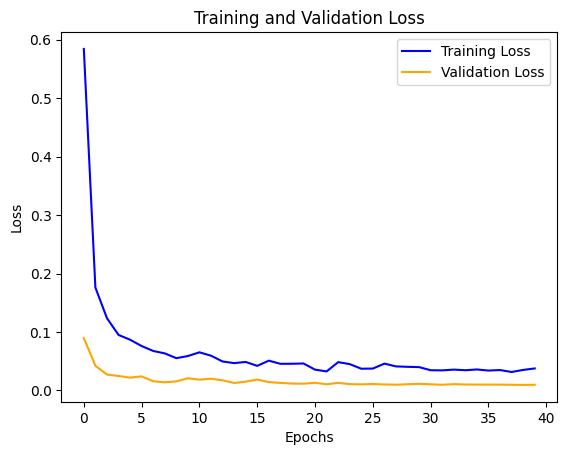

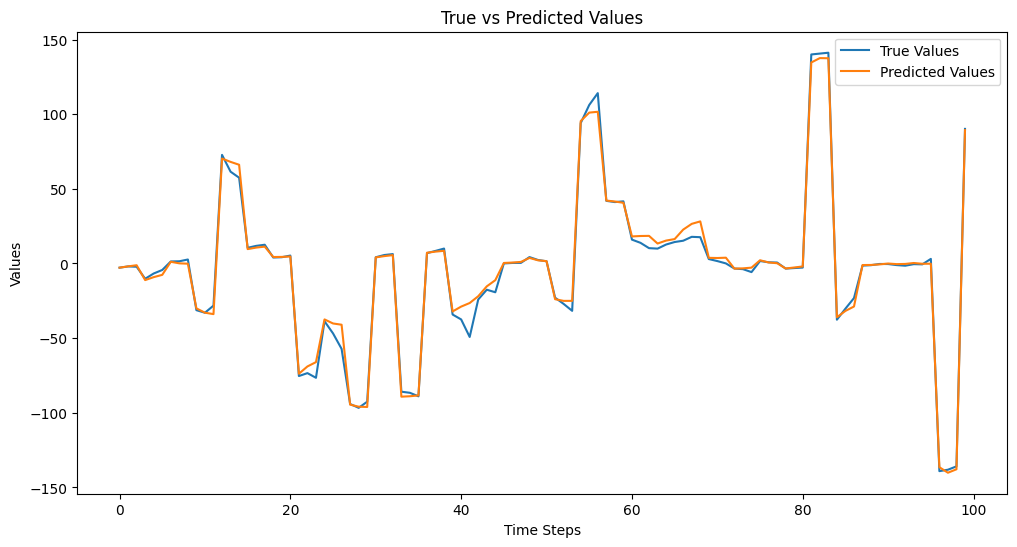

In [46]:
train_LSTM_model(X, y_serie, lr=0.001, patience_early_stop=8, patience_scheduler=4, num_of_epochs=40)

52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step


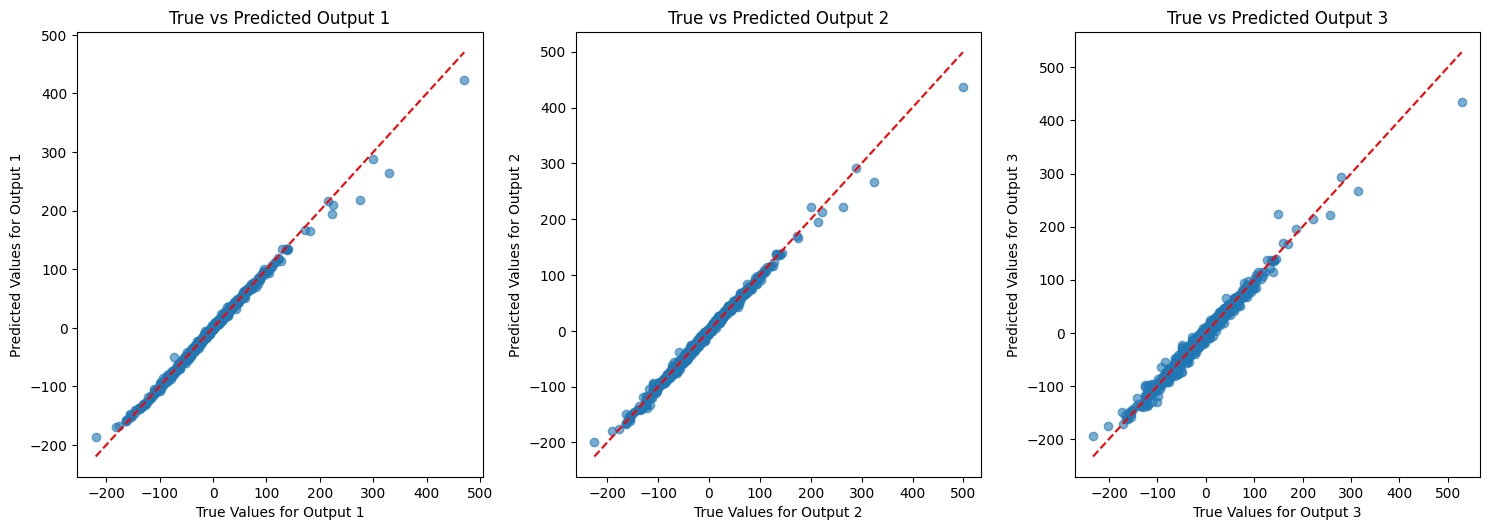

In [47]:
model_serie = Sequential([
    Input(shape=(1, X_train.shape[2])),
    LSTM(100, return_sequences=True, activation='tanh'),  # First LSTM layer with ReLU activation
    #Dropout(0.1),
    LSTM(64, return_sequences=True, activation='tanh'),                         # Fourth LSTM layer (last, no return_sequences)
    #Dropout(0.1),
    LSTM(32, return_sequences=True, activation='tanh'),                         # Fourth LSTM layer (last, no return_sequences)
    #Dropout(0.1),
    LSTM(3, activation='linear')                         # Final LSTM layer to predict 5 values
])

model_serie.load_weights('/content/serie.weights.h5')

y_pred = model_serie.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred)
y_test = scaler_y.inverse_transform(y_test)

plt.figure(figsize=(15, 10))

# Loop through each dimension of the output
for i in range(3):
    plt.subplot(2, 3, i+1)  # Create subplots for each of the 5 outputs
    plt.scatter(y_serie_test[:, i], y_pred[:, i], alpha=0.6)
    plt.xlabel(f'True Values for Output {i+1}')
    plt.ylabel(f'Predicted Values for Output {i+1}')
    plt.title(f'True vs Predicted Output {i+1}')
    plt.plot([min(y_serie_test[:, i]), max(y_serie_test[:, i])], [min(y_serie_test[:, i]), max(y_serie_test[:, i])], 'r--')  # Ideal line

plt.tight_layout()
plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 419ms/step


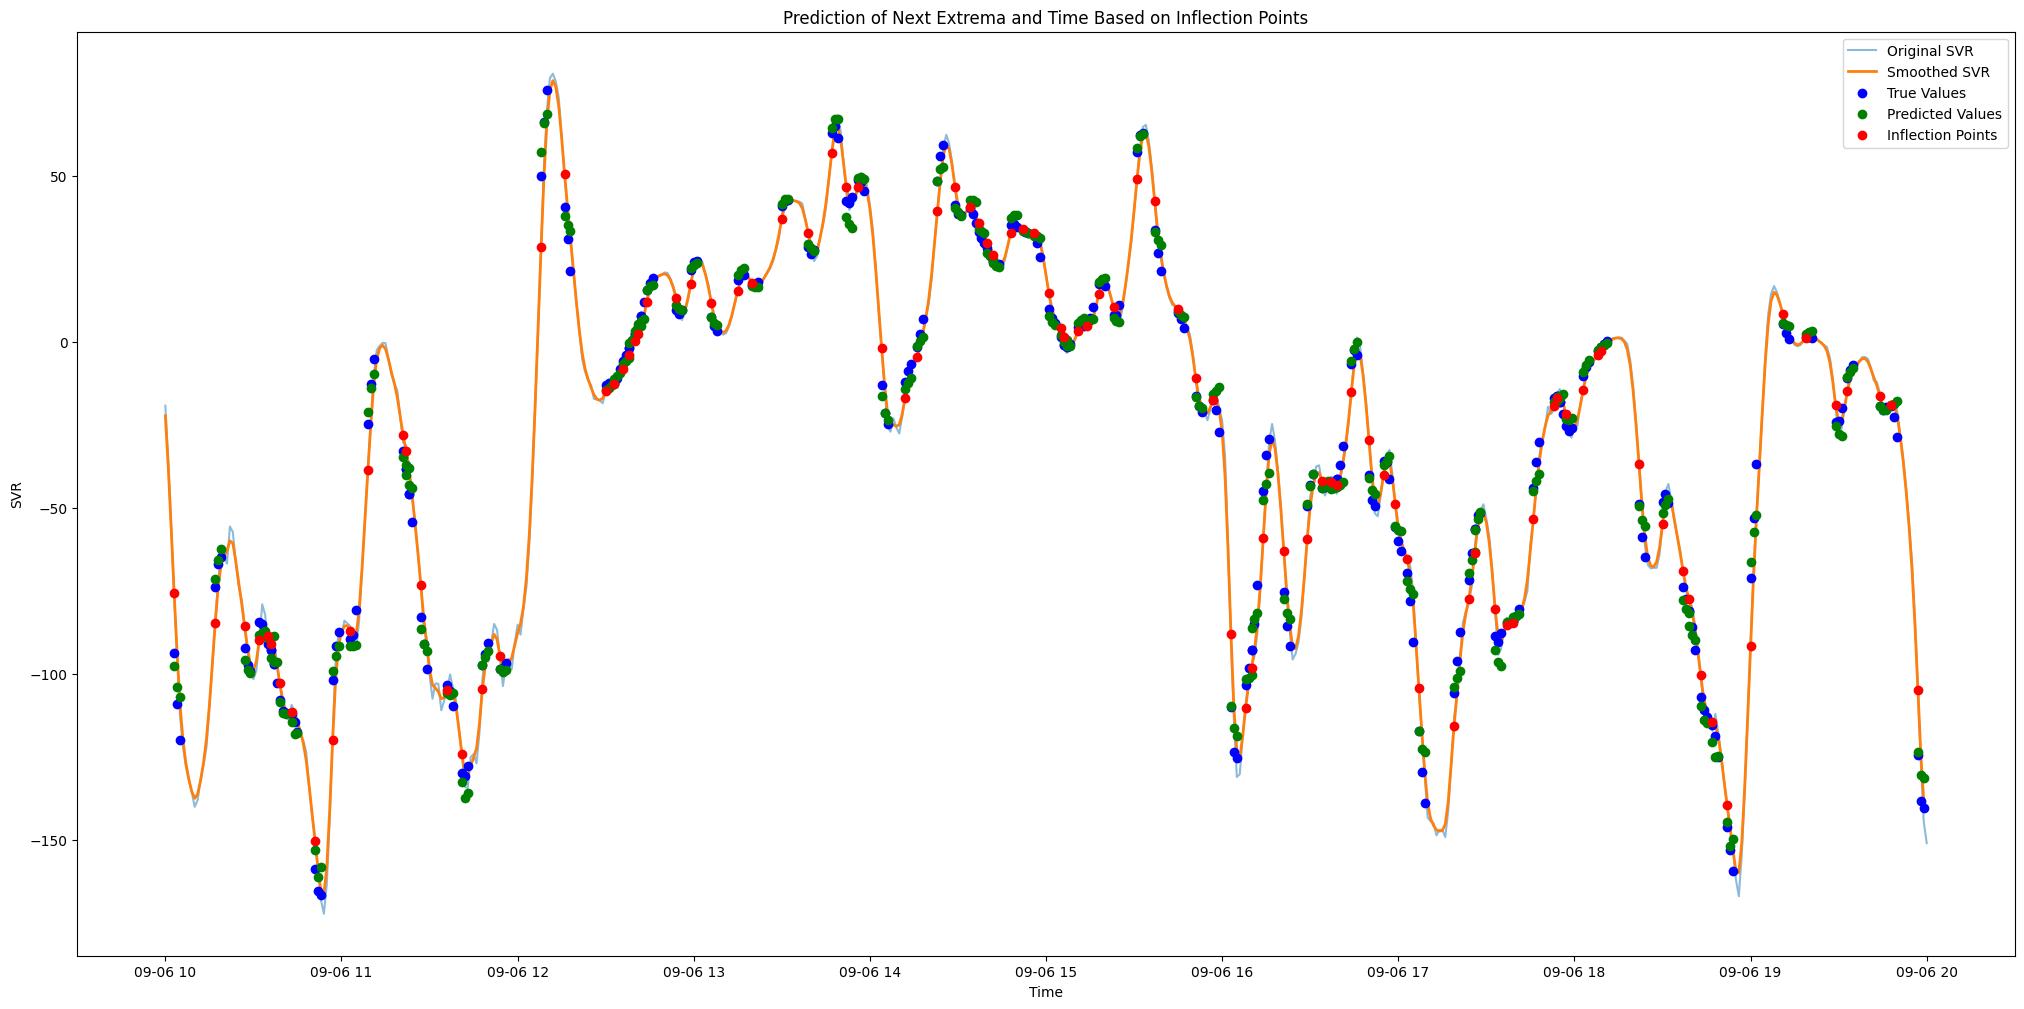

In [50]:
model_serie = Sequential([
    Input(shape=(1, X_train.shape[2])),
    LSTM(100, return_sequences=True, activation='tanh'),  # First LSTM layer with ReLU activation
    #Dropout(0.1),
    LSTM(64, return_sequences=True, activation='tanh'),                         # Fourth LSTM layer (last, no return_sequences)
    #Dropout(0.1),
    LSTM(32, return_sequences=True, activation='tanh'),                         # Fourth LSTM layer (last, no return_sequences)
    #Dropout(0.1),
    LSTM(3, activation='linear')                         # Final LSTM layer to predict 5 values
])

model_serie.load_weights('/content/serie.weights.h5')

start_time='2024-09-06 10:00:00'
end_time='2024-09-06 20:00:00'

filtered_SVR = SVR[(SVR['Time'] >= start_time) & (SVR['Time'] <= end_time)]
valid_rows_filtered = valid_rows_serie[(valid_rows_serie['Time'] >= start_time) & (valid_rows_serie['Time'] <= end_time)]

X_plot = valid_rows_filtered[['time_prev', 'amp_diff', 'prev_extrema_value',
                                'last_values_1', 'last_values_2',
                                'last_values_3', 'last_values_4',
                                'last_values_5', 'last_values_6',
                                'last_values_7', 'last_values_8',
                                'last_values_9', 'last_values_10',
                                'smoothed_SVR', 'previous_inflections']].values

y_plot = valid_rows_filtered[['next_values_1', 'next_values_2', 'next_values_3']].values

X_plot = scaler.transform(X_plot)
X_plot = X_plot.reshape((X_plot.shape[0], 1, X_plot.shape[1]))  # (samples, time_steps, features)

predicted_values = model_serie.predict(X_plot)
predicted_values = scaler_y.inverse_transform(predicted_values)

predicted_time_values = [
    pd.date_range(start=time, periods=3, freq='1min')
    for time in valid_rows_filtered['Time']]

predicted_time_flat = [time for times in predicted_time_values for time in times]
predicted_values_flat = predicted_values.flatten()

# Plot the results
plt.figure(figsize=(25, 12))
plt.plot(filtered_SVR['Time'], filtered_SVR['SVR'], label='Original SVR', alpha=0.5)
plt.plot(filtered_SVR['Time'], filtered_SVR['smoothed_SVR'], label='Smoothed SVR', linewidth=2)
plt.scatter(predicted_time_flat, y_plot, color='blue', label='True Values', zorder=5)
plt.scatter(predicted_time_flat, predicted_values_flat, color='green', label='Predicted Values', zorder=5)
plt.scatter(valid_rows_filtered['Time'], valid_rows_filtered['smoothed_SVR'], color='red',
            label='Inflection Points', zorder=5)
plt.title('Prediction of Next Extrema and Time Based on Inflection Points')
plt.xlabel('Time')
plt.ylabel('SVR')
plt.legend()
plt.show()

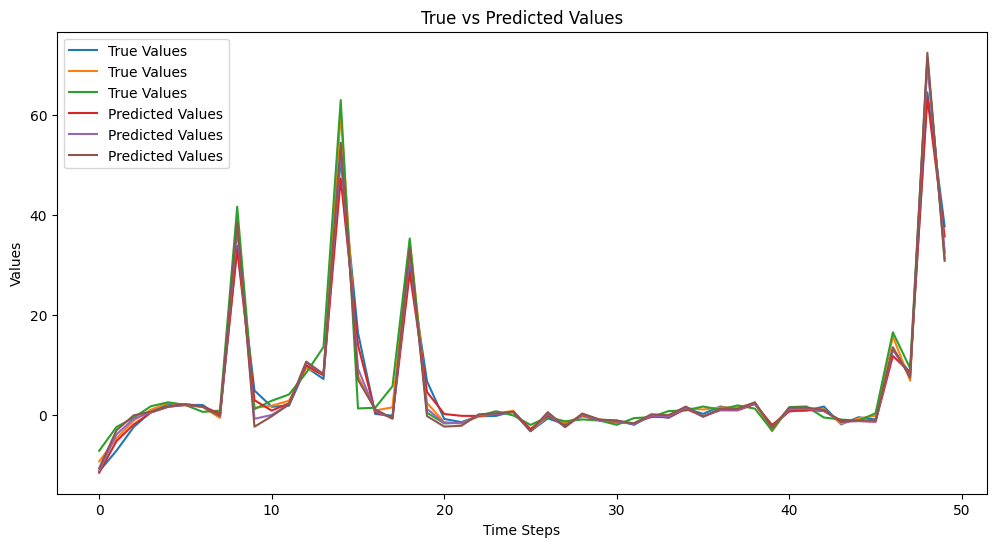

In [ ]:
# Assuming time ranges match `y_test_original` and `y_pred`
plt.figure(figsize=(12, 6))
plt.plot(y_plot[:50], label='True Values')  # Plot the first 50 true values
plt.plot(predicted_values[:50], label='Predicted Values')     # Plot the first 50 predictions
plt.xlabel('Time Steps')
plt.ylabel('Values')
plt.title('True vs Predicted Values')
plt.legend()
plt.show()